<a href="https://colab.research.google.com/github/drMy5tery/SPR-lab/blob/main/2448540_Lab1_SPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1 — Sampling and Reconstruction of Speech Signals

**Aim:** Study sampling, reconstruction (ZOH and linear interpolation), quantization, and implement a source–filter speech model.  
**How to use this notebook:** paste each Markdown cell and the following Code cell into your Jupyter notebook in order. If you have a real speech file, name it `input.wav` and put it in the same folder; otherwise the notebook will synthesize a speech-like signal automatically.

**Requirements:** `numpy`, `scipy`, `matplotlib`, `pandas`, `IPython` (for audio playback). If not installed, run `pip install numpy scipy matplotlib pandas`.


In [1]:
# Cell 2: Imports and global configuration
# Run this cell first.

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import pandas as pd
from fractions import Fraction
from IPython.display import Audio, display

# plotting defaults
plt.rcParams['figure.figsize'] = (10, 3)
plt.rcParams['figure.dpi'] = 100

# Reproducibility for synthetic signals
np.random.seed(0)

# Sampling rates we will use across the notebook (you can modify)
TARGET_SR = [44100, 16000, 8000]  # Hz

## Load or synthesize the "original" high-fidelity speech signal

This cell tries to load `input.wav` from the working directory.  
- If found, it loads the WAV (if stereo, uses first channel) and normalizes it.  
- If not found, it synthesizes a voiced vowel-like signal at 44.1 kHz using a harmonic source and an all-pole vocal-tract-like filter.  
We keep the "original" at a high sampling rate (44.1 kHz) to treat it as the ground-truth high-resolution signal.


In [2]:
# Cell 4: Load input.wav if present, else synthesize a vowel-like signal

def normalize(x):
    """Remove DC and scale to +/-1."""
    x = np.array(x, dtype=float)
    x = x - np.mean(x)
    m = np.max(np.abs(x))
    if m == 0:
        return x
    return x / m

# If you have a real WAV named 'input.wav', it'll be used; otherwise synthesize.
if os.path.exists("input.wav"):
    fs_orig, data = wavfile.read("input.wav")
    if data.ndim > 1:
        data = data[:, 0]  # use first channel if stereo
    orig_fs = fs_orig
    orig_signal = normalize(data)
    print(f"Loaded 'input.wav' with sample rate = {orig_fs} Hz, length = {len(orig_signal)/orig_fs:.2f} s")
else:
    # Synthesize
    orig_fs = 44100
    duration = 2.0  # seconds
    t = np.linspace(0, duration, int(orig_fs * duration), endpoint=False)
    f0 = 120.0  # fundamental frequency (pitch)
    # Harmonic-rich source: sum of harmonics with decreasing amplitude
    source = np.zeros_like(t)
    for h in range(1, 21):
        source += (1.0 / h) * np.sin(2 * np.pi * h * f0 * t)
    # Smooth envelope to mimic syllable-like amplitude
    envelope = np.hanning(len(t))
    source *= envelope

    # All-pole vocal-tract resonators (example formants for vowel /a/)
    formants = [730, 1090, 2440]   # Hz
    bandwidths = [80, 90, 120]     # Hz
    a = np.array([1.0])
    for f, bw in zip(formants, bandwidths):
        r = np.exp(-np.pi * bw / orig_fs)  # pole radius from bandwidth
        theta = 2 * np.pi * f / orig_fs
        a = np.convolve(a, [1, -2 * r * np.cos(theta), r**2])
    b = np.array([1.0])
    synth = signal.lfilter(b, a, source)
    orig_signal = normalize(synth)
    print(f"Synthesized voiced vowel-like signal at {orig_fs} Hz, length = {len(orig_signal)/orig_fs:.2f} s")

# Common time axis for the original hi-res signal
orig_len = len(orig_signal)
orig_time = np.arange(orig_len) / orig_fs

# Optionally listen to the original (works in Jupyter)
print("Original sample rate:", orig_fs)
display(Audio(orig_signal, rate=orig_fs))


Synthesized voiced vowel-like signal at 44100 Hz, length = 2.00 s
Original sample rate: 44100


## Plot original (time domain) — short view and full view

We plot:
- a short time window (first 40 ms) for waveform detail (good to see sampling/reconstruction later),
- and a longer chunk or the full signal overview.


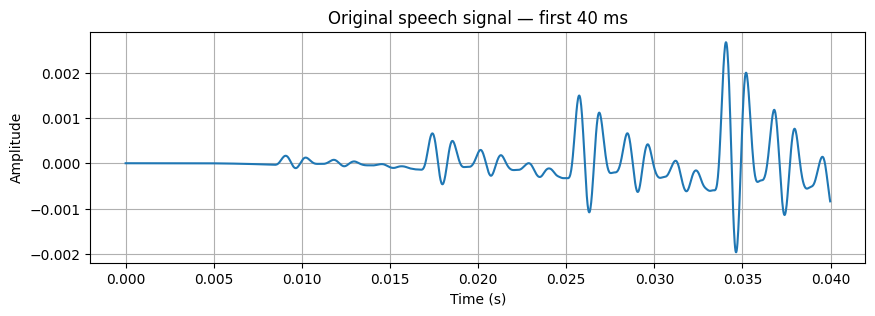

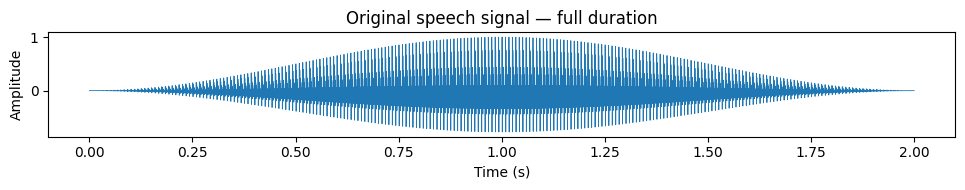

In [3]:
# Cell 6: Plot short segment and full waveform

# Short segment for detail (first 40 ms)
short_ms = 40
idx_end = int(min(orig_len, (short_ms / 1000) * orig_fs))
plt.figure()
plt.plot(orig_time[:idx_end], orig_signal[:idx_end])
plt.title(f"Original speech signal — first {short_ms} ms")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Full waveform (may be long)
plt.figure(figsize=(10, 2))
plt.plot(orig_time, orig_signal, linewidth=0.6)
plt.title("Original speech signal — full duration")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


## Sampling (resampling) at different rates

We will simulate ADC sampling at multiple target rates by resampling the high-resolution original:
- Use `scipy.signal.resample_poly` for anti-aliased resampling (good for downsampling).
- Save sampled signals and their time axes for later reconstruction.

We keep the original high-res signal fixed as the reference (ground truth).


Resampled to 44100 Hz: 88200 samples (p=1, q=1)


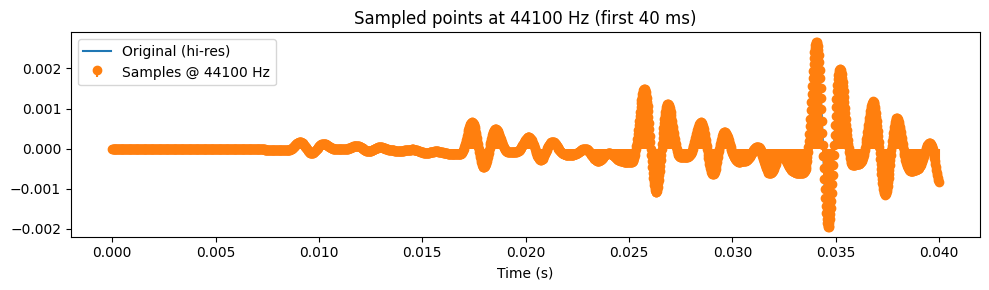

Resampled to 16000 Hz: 32000 samples (p=160, q=441)


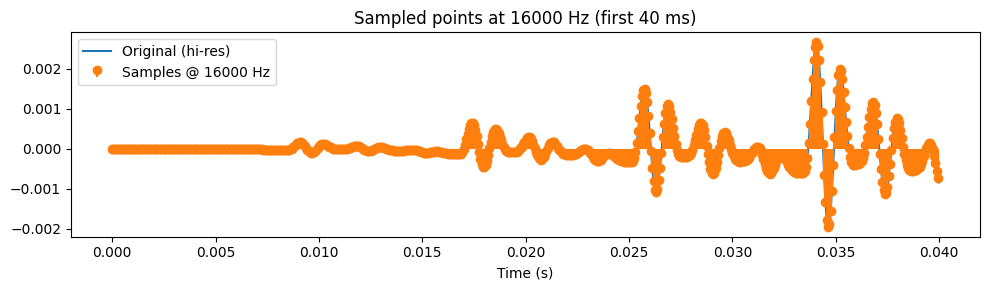

Resampled to 8000 Hz: 16000 samples (p=80, q=441)


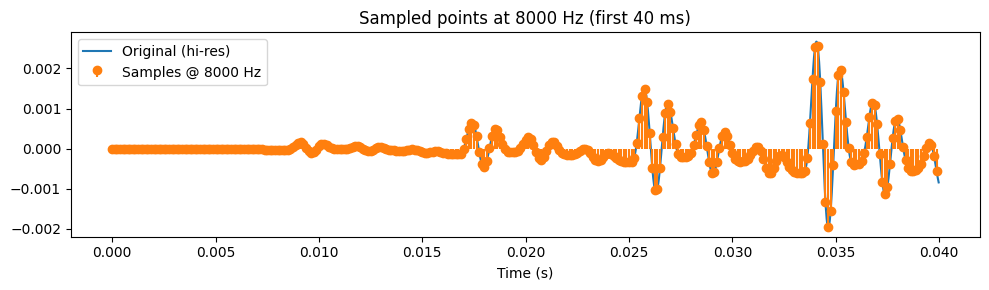

In [5]:
# Cell 8: Resample original signal to each target sampling rate and plot sampled points

sampled_signals = {}   # sampled_signals[fs] = numpy array of samples
sample_times = {}      # sample_times[fs] = times for those samples

for fs_t in TARGET_SR:
    # Use a rational approximation for the resample_poly up/down factors
    ratio = fs_t / orig_fs
    frac = Fraction(ratio).limit_denominator(1000)
    p, q = frac.numerator, frac.denominator

    # resample_poly performs anti-aliased resampling
    sampled = signal.resample_poly(orig_signal, p, q)
    t_sampled = np.arange(len(sampled)) / fs_t
    sampled_signals[fs_t] = sampled
    sample_times[fs_t] = t_sampled
    print(f"Resampled to {fs_t} Hz: {len(sampled)} samples (p={p}, q={q})")

    # Plot sampled points overlayed on the original (short window)
    plt.figure()
    plt.plot(orig_time[:idx_end], orig_signal[:idx_end], label="Original (hi-res)")
    mask = t_sampled <= orig_time[idx_end - 1]
    # stem plot to show the discrete samples
    plt.stem(t_sampled[mask], sampled[mask], linefmt='C1-', markerfmt='C1o', basefmt=" ", label=f"Samples @ {fs_t} Hz")
    plt.title(f"Sampled points at {fs_t} Hz (first {short_ms} ms)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Quantization (uniform mid-rise) of sampled signals

Quantization converts continuous-valued samples into discrete amplitude levels (bits).  
We implement a uniform quantizer that:
- maps samples to the range [-1, 1],
- quantizes into `2^bits` levels,
- returns quantized samples in the same range.

We will demonstrate quantization for e.g., 8-bit and 12-bit depths and observe effect on reconstruction MSE.


In [6]:
# Cell 10: Quantization functions and examples

def quantize_uniform(x, bits):
    """Uniform mid-rise quantizer over [-1,1].
    x assumed normalized in [-1,1]. Returns quantized signal in [-1,1]"""
    x = np.clip(x, -1.0, 1.0)
    levels = 2 ** bits
    # Map x from [-1,1] to [0, levels-1] then round, then map back
    scaled = (x + 1.0) * (levels / 2.0)  # in [0, levels]
    # Use floor to make mid-rise (or use np.round for symmetric rounding)
    idx = np.floor(scaled).astype(int)
    idx = np.clip(idx, 0, levels - 1)
    quant = (idx + 0.5) / (levels / 2.0) - 1.0  # center of each bin -> back to [-1,1]
    return quant

# Demonstrate quantization on one sampled set (e.g., 16 kHz)
demo_fs = 16000
demo_samples = sampled_signals[demo_fs]
for bits in [8, 12]:
    q = quantize_uniform(demo_samples, bits)
    # show a tiny segment numeric comparison
    print(f"First 8 samples @ {demo_fs} Hz, quantized to {bits}-bit:")
    print("orig:", np.round(demo_samples[:8], 4))
    print("quant:", np.round(q[:8], 4))
    print()


First 8 samples @ 16000 Hz, quantized to 8-bit:
orig: [0. 0. 0. 0. 0. 0. 0. 0.]
quant: [0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039]

First 8 samples @ 16000 Hz, quantized to 12-bit:
orig: [0. 0. 0. 0. 0. 0. 0. 0.]
quant: [0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002]



## Reconstruction methods to implement

We implement two reconstructions from the discrete-time samples:
1. **Zero-Order Hold (ZOH)** — hold the last sample value until the next sample (step waveform).
2. **Linear interpolation** — piecewise-linear interpolation between adjacent samples.

Both will reconstruct to the original high-resolution time axis (so we can compute MSE vs the original ground truth).


In [15]:
# Cell 12: Reconstruction functions (ZOH and linear)

def reconstruct_zoh(t_sampled, x_sampled, t_target):
    """
    Zero-Order Hold reconstruction:
    For each target time, pick the latest sampled value at or before that time.
    """
    # np.searchsorted returns index where element should be inserted to keep order
    idx = np.searchsorted(t_sampled, t_target, side='right') - 1
    idx[idx < 0] = 0  # for times before first sample, use first sample
    return x_sampled[idx]

def reconstruct_linear(t_sampled, x_sampled, t_target):
    """
    Linear interpolation (numpy.interp).
    Values outside the sampled time range will be filled by edge sample values.
    """
    return np.interp(t_target, t_sampled, x_sampled)

## Reconstruct sampled signals (with and without quantization) and compute MSE

For each sampling rate we will:
- Reconstruct using ZOH and Linear interpolation from the raw sampled values.
- Optionally quantize the sampled values (e.g., 8-bit, 12-bit), then reconstruct from quantized values.
- Compute Mean Squared Error (MSE) w.r.t. the original high-resolution signal.

We will collect and print MSE tables for:
- reconstruction from raw samples (no amplitude quantization),
- reconstruction from quantized samples (showing effect of amplitude quantization).


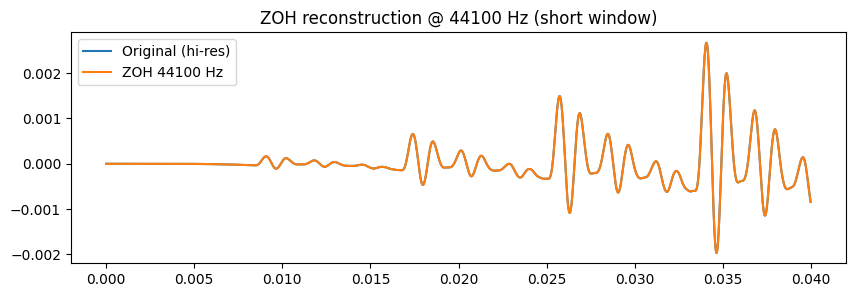

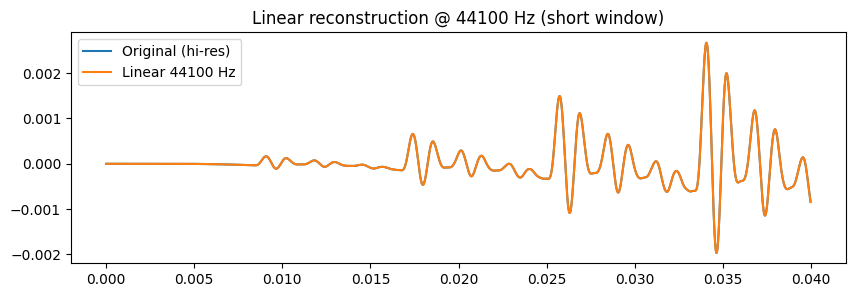

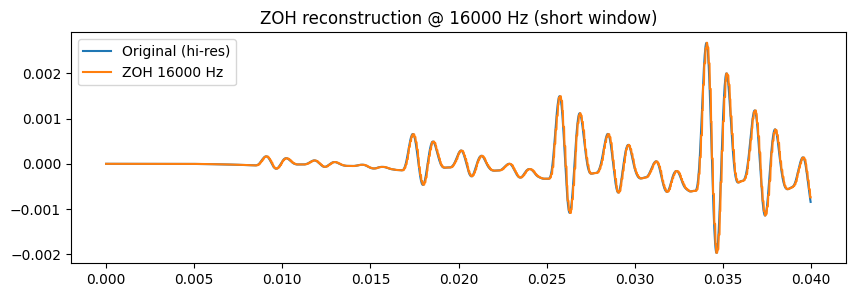

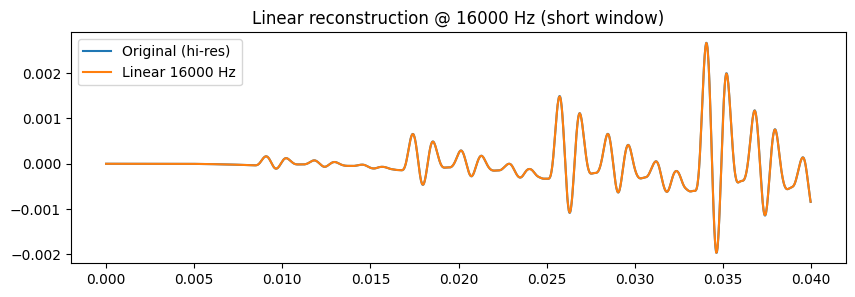

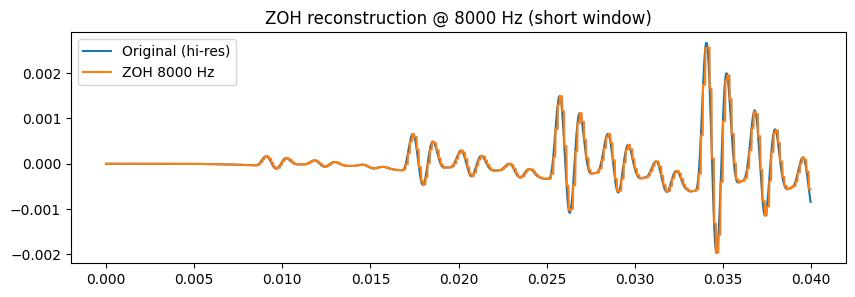

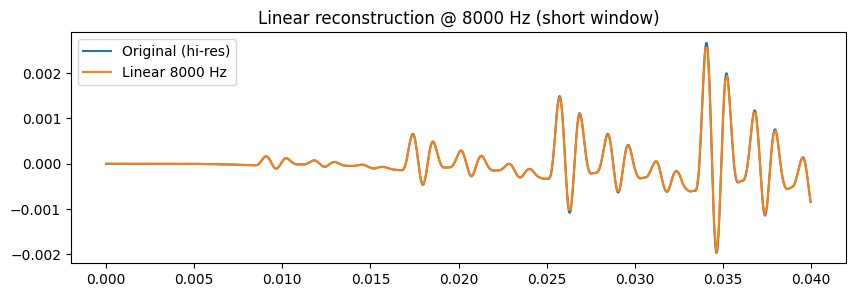

MSE - reconstruction from raw sampled values:


,sampling_rate,mse_zoh,mse_linear
0,44100,0.000000,0.000000
1,16000,0.001269,0.000003
2,8000,0.004957,0.000057



MSE - reconstruction from quantized sampled values:


,sampling_rate,bits,mse_zoh,mse_linear
0,44100,8,5.426443e-06,5.426443e-06
1,44100,12,2.022484e-08,2.022484e-08
2,16000,8,1.272069e-03,6.895522e-06
3,16000,12,1.268701e-03,3.003904e-06
4,8000,8,4.961482e-03,6.041917e-05
5,8000,12,4.957042e-03,5.661915e-05


In [16]:
# Cell 14: Reconstruction and MSE computation

mse_records = []          # for raw-samples reconstructions
mse_records_quant = []    # for quantized-sample reconstructions

quant_bits_list = [8, 12]  # bits to try for quantization demonstration

for fs_t in TARGET_SR:
    t_s = sample_times[fs_t]
    x_s = sampled_signals[fs_t]
    # Reconstruct to the original time base
    rec_zoh = reconstruct_zoh(t_s, x_s, orig_time)
    rec_lin = reconstruct_linear(t_s, x_s, orig_time)

    mse_zoh = np.mean((orig_signal - rec_zoh) ** 2)
    mse_lin = np.mean((orig_signal - rec_lin) ** 2)

    mse_records.append({"sampling_rate": fs_t, "mse_zoh": mse_zoh, "mse_linear": mse_lin})

    # For each quantization level, quantize the sample values then reconstruct and compute MSE
    for bits in quant_bits_list:
        xq = quantize_uniform(x_s, bits)
        rec_zoh_q = reconstruct_zoh(t_s, xq, orig_time)
        rec_lin_q = reconstruct_linear(t_s, xq, orig_time)
        mse_z_q = np.mean((orig_signal - rec_zoh_q) ** 2)
        mse_l_q = np.mean((orig_signal - rec_lin_q) ** 2)
        mse_records_quant.append({"sampling_rate": fs_t, "bits": bits, "mse_zoh": mse_z_q, "mse_linear": mse_l_q})

    # Plot comparison of reconstructions (short window)
    plt.figure()
    plt.plot(orig_time[:idx_end], orig_signal[:idx_end], label="Original (hi-res)")
    plt.plot(orig_time[:idx_end], rec_zoh[:idx_end], label=f"ZOH {fs_t} Hz")
    plt.title(f"ZOH reconstruction @ {fs_t} Hz (short window)")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(orig_time[:idx_end], orig_signal[:idx_end], label="Original (hi-res)")
    plt.plot(orig_time[:idx_end], rec_lin[:idx_end], label=f"Linear {fs_t} Hz")
    plt.title(f"Linear reconstruction @ {fs_t} Hz (short window)")
    plt.legend()
    plt.show()

# Summarize results in dataframes
mse_df = pd.DataFrame(mse_records).sort_values("sampling_rate", ascending=False).reset_index(drop=True)
mse_quant_df = pd.DataFrame(mse_records_quant).sort_values(["sampling_rate", "bits"], ascending=[False, True]).reset_index(drop=True)

print("MSE - reconstruction from raw sampled values:")
display(mse_df)

print("\nMSE - reconstruction from quantized sampled values:")
display(mse_quant_df)

# Save CSVs for your lab manual
mse_df.to_csv("mse_reconstruction_raw.csv", index=False)
mse_quant_df.to_csv("mse_reconstruction_quantized.csv", index=False)

## Part 2 — Source–Filter Model

We now implement a simple source–filter model:
1. **Source:** glottal pulse train (periodic impulses shaped by a short glottal waveform) + small unvoiced noise.
2. **Filter:** an all-pole vocal-tract approximation constructed from chosen formant frequencies and bandwidths.

We then:
- Plot source and filtered signals,
- Plot magnitude spectra to show formants,
- Sample the filtered synthetic signal at target rates and repeat reconstruction + MSE analysis.


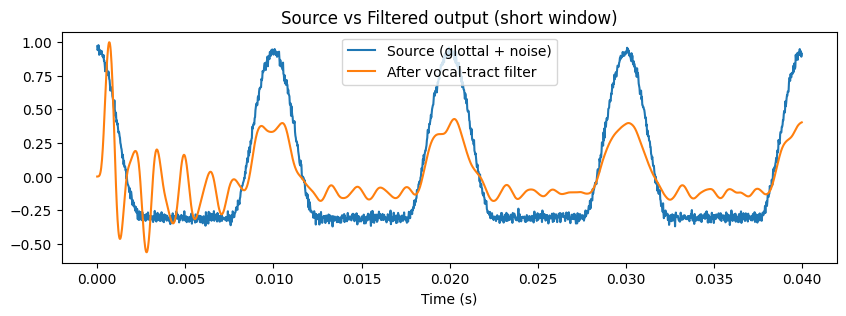

Filtered synthetic speech (source-filter) — listen below:


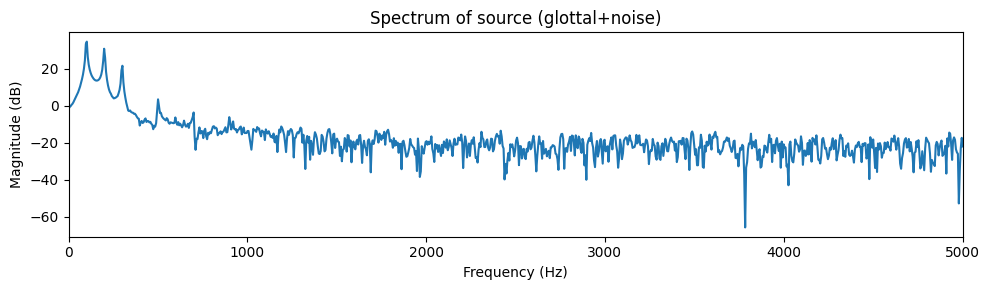

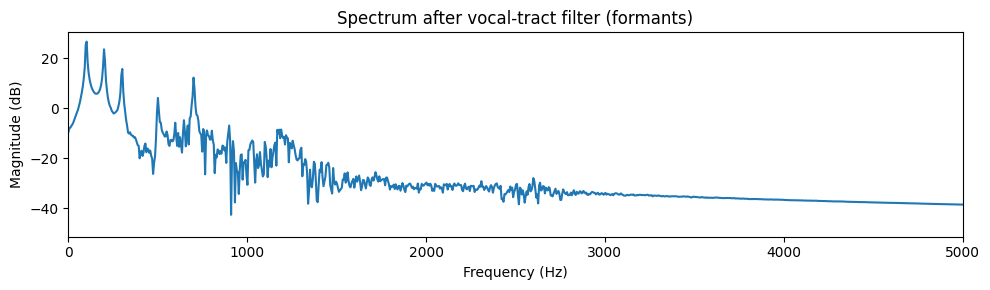

In [17]:
# Cell 16: Build source-filter synthetic speech (glottal + vocal tract)

# Parameters
duration = 2.0
t = np.linspace(0, duration, int(orig_fs * duration), endpoint=False)

# --- Source (glottal pulse train) ---
f0 = 100.0  # fundamental frequency (Hz)
step = int(orig_fs / f0)
impulse_train = np.zeros_like(t)
indices = np.arange(0, len(t), step).astype(int)
indices = indices[indices < len(t)]
impulse_train[indices] = 1.0

# shape each impulse with a short glottal pulse (approximate Rosenberg or sinusoidal pulse)
glottal_len = int(0.005 * orig_fs)  # 5 ms pulse
gt = np.linspace(0, 1, glottal_len)
glottal_shape = (np.sin(np.pi * gt)) ** 2
glottal_source = np.convolve(impulse_train, glottal_shape, mode='same')

# Add some unvoiced energy (white noise), then mix
white_noise = np.random.normal(scale=0.3, size=len(t))
source_signal = 0.9 * normalize(glottal_source) + 0.1 * normalize(white_noise)
source_signal = normalize(source_signal)

# --- Vocal tract (all-pole resonators) ---
formants = [700, 1200, 2600]  # example formants (Hz)
bandwidths = [70, 100, 120]   # example bandwidths (Hz)
a = np.array([1.0])
for f, bw in zip(formants, bandwidths):
    r = np.exp(-np.pi * bw / orig_fs)
    theta = 2 * np.pi * f / orig_fs
    a = np.convolve(a, [1, -2 * r * np.cos(theta), r**2])
b = np.array([1.0])

filtered_speech = signal.lfilter(b, a, source_signal)
filtered_speech = normalize(filtered_speech)

# Plot source vs filtered (short view) and play
plt.figure()
plt.plot(t[:idx_end], source_signal[:idx_end], label="Source (glottal + noise)")
plt.plot(t[:idx_end], filtered_speech[:idx_end], label="After vocal-tract filter")
plt.title("Source vs Filtered output (short window)")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

# Display audio for filtered synthetic speech
print("Filtered synthetic speech (source-filter) — listen below:")
display(Audio(filtered_speech, rate=orig_fs))

# Plot magnitude spectra to show formants (use windowed FFT)
def plot_spectrum(x, fs, title, nfft=8192):
    w = signal.windows.hann(len(x))
    X = np.fft.rfft(x * w, n=nfft)
    freqs = np.fft.rfftfreq(nfft, 1 / fs)
    mag = 20 * np.log10(np.abs(X) + 1e-12)
    plt.figure()
    plt.plot(freqs, mag)
    plt.xlim(0, 5000)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_spectrum(source_signal, orig_fs, "Spectrum of source (glottal+noise)")
plot_spectrum(filtered_speech, orig_fs, "Spectrum after vocal-tract filter (formants)")


## Sample the synthetic filtered speech and reconstruct

We repeat the sampling → (optionally quantize) → reconstruct → MSE steps for the synthetic filtered signal.  
This shows how sampling and amplitude quantization affect a synthetic speech signal whose spectral peaks (formants) we designed.


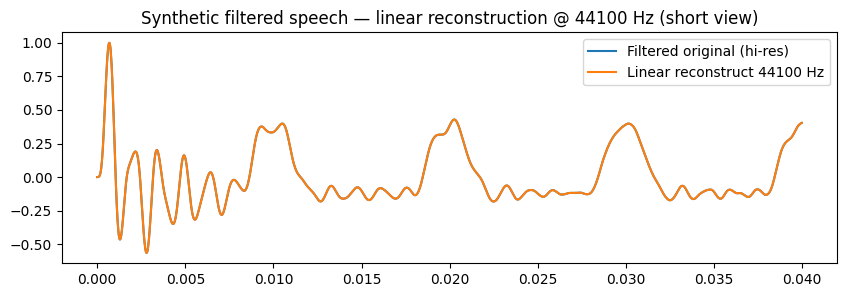

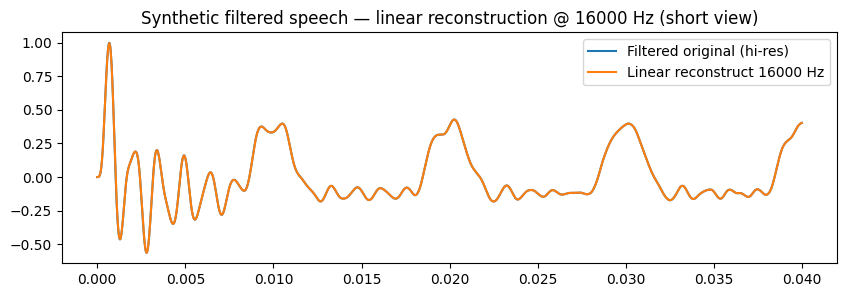

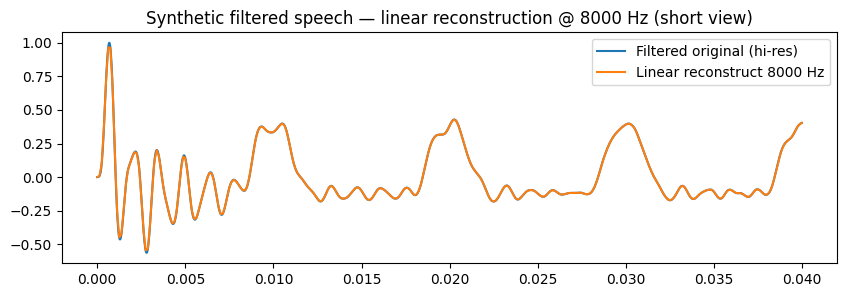

MSE — synthetic source-filter signal (raw samples):


,sampling_rate,mse_zoh,mse_linear
0,44100,0.000000,0.000000e+00
1,16000,0.000067,6.000501e-08
2,8000,0.000266,1.128924e-06



MSE — synthetic signal (quantized sampled values):


,sampling_rate,bits,mse_zoh,mse_linear
0,44100,8,5.091929e-06,5.091929e-06
1,44100,12,1.987893e-08,1.987893e-08
2,16000,8,7.255884e-05,3.460724e-06
3,16000,12,6.743795e-05,7.369005e-08
4,8000,8,2.711121e-04,4.516754e-06
5,8000,12,2.656033e-04,1.141579e-06


In [18]:
# Cell 18: Sample synthetic filtered speech and compute MSEs

sampled_synth = {}
sampled_synth_times = {}
mse_synth = []
mse_synth_quant = []

for fs_t in TARGET_SR:
    ratio = fs_t / orig_fs
    frac = Fraction(ratio).limit_denominator(1000)
    p, q = frac.numerator, frac.denominator
    s_sampled = signal.resample_poly(filtered_speech, p, q)
    t_sampled = np.arange(len(s_sampled)) / fs_t
    sampled_synth[fs_t] = s_sampled
    sampled_synth_times[fs_t] = t_sampled

    # reconstruct to original time base
    rec_zoh = reconstruct_zoh(t_sampled, s_sampled, orig_time)
    rec_lin = reconstruct_linear(t_sampled, s_sampled, orig_time)
    mse_z = np.mean((filtered_speech - rec_zoh) ** 2)
    mse_l = np.mean((filtered_speech - rec_lin) ** 2)
    mse_synth.append({"sampling_rate": fs_t, "mse_zoh": mse_z, "mse_linear": mse_l})

    # quantized example
    for bits in [8, 12]:
        s_q = quantize_uniform(s_sampled, bits)
        rec_z_q = reconstruct_zoh(t_sampled, s_q, orig_time)
        rec_l_q = reconstruct_linear(t_sampled, s_q, orig_time)
        mse_zq = np.mean((filtered_speech - rec_z_q) ** 2)
        mse_lq = np.mean((filtered_speech - rec_l_q) ** 2)
        mse_synth_quant.append({"sampling_rate": fs_t, "bits": bits, "mse_zoh": mse_zq, "mse_linear": mse_lq})

    # Plot synthetic linear reconstruction (short view)
    plt.figure()
    plt.plot(orig_time[:idx_end], filtered_speech[:idx_end], label="Filtered original (hi-res)")
    plt.plot(orig_time[:idx_end], rec_lin[:idx_end], label=f"Linear reconstruct {fs_t} Hz")
    plt.title(f"Synthetic filtered speech — linear reconstruction @ {fs_t} Hz (short view)")
    plt.legend()
    plt.show()

# Summarize
mse_synth_df = pd.DataFrame(mse_synth).sort_values("sampling_rate", ascending=False).reset_index(drop=True)
mse_synth_q_df = pd.DataFrame(mse_synth_quant).sort_values(["sampling_rate", "bits"], ascending=[False, True]).reset_index(drop=True)

print("MSE — synthetic source-filter signal (raw samples):")
display(mse_synth_df)

print("\nMSE — synthetic signal (quantized sampled values):")
display(mse_synth_q_df)

# Save CSVs for lab manual
mse_synth_df.to_csv("mse_synth_reconstruction_raw.csv", index=False)
mse_synth_q_df.to_csv("mse_synth_reconstruction_quantized.csv", index=False)




- As sampling rate decreases, MSE between original and reconstructed signal increases (less high-frequency content is captured).
- Linear interpolation consistently yields lower MSE than ZOH (smoother transitions, fewer high-frequency reconstruction artifacts).
- Quantization (reduced bits) increases amplitude error and raises MSE; low-bit quantization is audible as distortion/noise.
- In the source-filter model, the filter imposes formant peaks in the spectrum. If sampling rate is too low (Nyquist < formant), those formants will be lost or aliased, degrading vowel quality / intelligibility.
- Practical note: 8 kHz can be sufficient for intelligibility (telephony), but 16 kHz or higher retains more timbral information.




In [19]:
# Cell 20: Print final summary and list saved files for your lab manual

print("Saved MSE CSVs (raw and quantized) for both original and synthetic signals:")
for fname in sorted([f for f in os.listdir('.') if f.endswith('.csv') or f.endswith('.png')]):
    print(" -", fname)

print("\nShort summary (copy into lab manual):")
print("- Linear interpolation gives lower MSE than ZOH across sampling rates.")
print("- Lower sampling rates and lower quantization bits both increase MSE and impair quality.")
print("- Source-filter model highlights importance of sampling rate relative to formant frequencies.")


Saved MSE CSVs (raw and quantized) for both original and synthetic signals:
 - mse_reconstruction_quantized.csv
 - mse_reconstruction_raw.csv
 - mse_synth_reconstruction_quantized.csv
 - mse_synth_reconstruction_raw.csv

Short summary (copy into lab manual):
- Linear interpolation gives lower MSE than ZOH across sampling rates.
- Lower sampling rates and lower quantization bits both increase MSE and impair quality.
- Source-filter model highlights importance of sampling rate relative to formant frequencies.
